In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib
import os, struct
import numpy as np
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
from pylab import *
from numpy import *
from collections import namedtuple
from sklearn.preprocessing import normalize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import KFold

In [7]:
def load_mnist(dataset="training", digits=np.arange(10), path="data/"):
    """Loads MNIST files into 3D numpy arrays

    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

def split_data():
    """Preprocess and return training and testing datasets.
    """
    images = namedtuple('MNIST_images', ['train', 'test'])
    labels = namedtuple('MNIST_labels', ['train', 'test'])
    images.train, labels.train = load_mnist('training')
    images.test, labels.test = load_mnist('testing')
    images.train = np.reshape(images.train, (images.train.shape[0],images.train.shape[1]*images.train.shape[2]))
    images.train = normalize(images.train.astype(np.float), axis=1)
    images.test = np.reshape(images.test, (images.test.shape[0],images.test.shape[1]*images.test.shape[2]))
    images.test = normalize(images.test.astype(np.float), axis=1)
    labels.train = np.reshape(labels.train, -1)
    labels.test = np.reshape(labels.test, -1)
    return images, labels

In [8]:
images, labels = split_data()

## Stacking method for multiclass classification

<br><center>_Oleksii Hrinchuk_<br>
<br><center>_Mikhail Karasikov_<br>
<br><center>_Olga Strazhevich_

## Problem

Build a classifier which can recognize handwritten digits from the MNIST database.

$X = \{x_i\}_{i=1}^n$ - images

$a:X \rightarrow \{0,\dots,9\}$

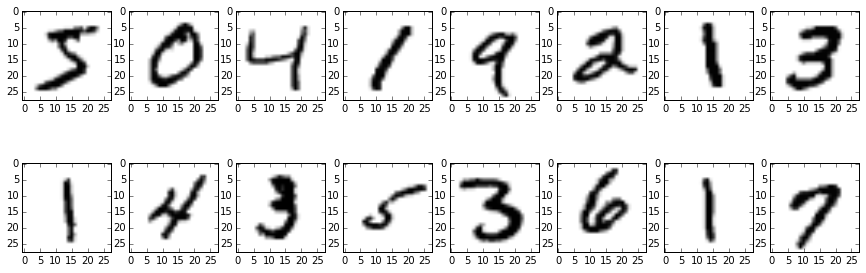

In [13]:
fig, ax = plt.subplots(2, 8, figsize = (15, 5))
for i in xrange(16):
    ax[i/8, i%8].imshow(np.reshape(1-images.train[i], (28, 28)), cmap = 'gray')

Quality function:
$$
Q(a) = \frac{1}{n} \sum_{i=1}^n I(a(x_i)=y_i)
$$

## Data preprocessing

* reshape images to vectors and use them as features
* apply Principal Component Analysis for dimensionality reduction

$X = USV^T \to \hat{X} = X V_r V_r^T$

## Basic classifiers

| Classifier        | Quality   |
| ----------------- |:---------:|
| Logistic regression      | $0.912$ | 
| Support Vector Machine   | $0.938$ |  
| Random Forest            | $0.928$ | 
| Extra Trees              | $0.930$ |

## Stacking

<img src="stacking.png">

### Splitting data to avoid underfitting
* Bootstrap
* Random
* K-fold

## Results



| Folding       | Quality   |
| ----------------- |:---------:|
| 3-fold     | $0.952$ | 
| 5-fold   | $0.959$ |  
| 10-fold          | $0.961$ | 
| 15-fold              | $\mathbf{0.964}$ |
| 20-fold              | $0.963$ |
| 40-fold   | $\mathbf{0.964}$ |  
| 50-fold          | $\mathbf{0.964}$ | 
| 100-fold              | $0.963$ |

| Base classifier       | Meta classifier |Quality   |
| ----------------- |-----------|:---------:|
| Logistic regression     | Support Vector Machine| $0.963$ | 
| Support Vector Machine  | Random Forest| $0.924$ |  
| Extra Trees          | Logistic regression| $0.958$ | 
| SVM (linear kernel)|SVM (poly kernel) | $0.963$ |
| Random Forest     | Support Vector Machine| $0.967$ | 
|Extra Trees     | Support Vector Machine| $\mathbf{0.977}$ | 

## Extensible code

In [25]:
class Stacking(object):
    """Base class for stacking method of learning.
    """
    
    def __init__(self, base_fitter, meta_fitter, 
                 split=lambda I: list(KFold(n=I.size, n_folds=2, shuffle=True)),
                 decision_rule=lambda estimations: max(set(estimations), 
                                                       key=estimations.count)):
        pass
        
    def fit(self, X, y):
        """Build compositions of classifiers.
        
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
         
        y : array-like, shape = [n_samples]
        
        Returns
        -------
        self : object
            Returns self.
        """
        pass
    
    def predict(self, X):
        """Predict class for X.
        
        The predicted class of an input sample is computed as the majority
        prediction of the meta-classifiers.
        
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
        
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        pass


In [26]:
class Classifier(object):
    """Classifier wrapper.
    """    
    def __init__(self, predict_function):
        self.predict = predict_function

def get_SVM_fitter(C=1., kernel='linear', degree=3, gamma=1.):
    return lambda X, y: Classifier(SVC(C=C, kernel=kernel, 
                                       degree=degree, gamma=gamma).fit(X, y).predict)

def SVM_fitter(X, y):
    classifier = SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X, y)
    return Classifier(classifier.predict)

def logit_fitter(X, y):
    classifier = LogisticRegression('l2', False).fit(X, y)
    return Classifier(classifier.predict)

def random_forest_fitter(X, y):
    classifier = RandomForestClassifier().fit(X, y)
    return Classifier(classifier.predict)

def random_forest_proba_fitter(X, y):
    classifier = RandomForestClassifier().fit(X, y)
    return Classifier(classifier.predict_proba)

def extra_trees_proba_fitter(X, y):
    classifier = ExtraTreesClassifier().fit(X, y)
    return Classifier(classifier.predict_proba)

In [27]:
wildfowl = Stacking(base_fitter=extra_trees_proba_fitter, 
                    meta_fitter=get_SVM_fitter(C=5, kernel='poly', degree = 2), 
                    split=lambda I: list(KFold(n=I.size, n_folds=5, shuffle=True)))